In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import pathlib
import scipy
%matplotlib inline
import numpy as np

Esse notebook visa comparar as diferenças de resultados ao variar a probabilidade de crossover (pc) e probabilidade de mutação (pm) para o caso de 100 indivíduos, 500 gerações e seleção por roleta.

Foram testadas duas configurações:
- pc=0.9 e pm=0.05
- pc=0.6 e pm=0.3

# 1 - Fitness média ao longo das gerações

In [2]:
results_folder_path = pathlib.Path('../../results/')

In [4]:
def get_fitness_data_per_config(folders_paths) -> list[dict]:
    data_per_config = dict()
    for target_folder in folders_paths:
        fitness_stats_path = target_folder / 'fitness_stats.csv'
        print(fitness_stats_path)
        stats_df = pd.read_csv(fitness_stats_path)
        folder_name_splitted = str(target_folder).split('/')[-1].split('_')
        if len(folder_name_splitted) < 3:
            config_name = 'pc_0.9_pm_0.05'
        else:
            config_name = 'pc_0.6_pm_0.3'
        
        data_per_config[config_name] = stats_df
    return data_per_config

In [8]:
results_folders = [results_folder_path / 'synth1/100pop_500gen', results_folder_path / 'synth1/100pop_500gen_rol_pc_pm']
data_per_selection = get_fitness_data_per_config(results_folders)

../../results/synth1/100pop_500gen/fitness_stats.csv
../../results/synth1/100pop_500gen_rol_pc_pm/fitness_stats.csv


In [13]:
data_per_selection['pc_0.9_pm_0.05'].head()

,train_fit,test_fit,train_time_seconds,random_seed
0,3.327364,3.207600,42.173110,178
1,3.516250,6.685075,32.000246,457
2,3.126235,3.671518,65.292992,128
3,9.027025,13.264174,76.268973,839
4,1.717624,2.044356,45.781714,484


In [21]:
def plot_fitness_results(data_dict, num_runs=30, base_dados='synth1'):
    train_data_colors = {'pc_0.9_pm_0.05':'red', 
                     'pc_0.6_pm_0.3':'green'}

    test_data_colors = {'pc_0.9_pm_0.05':'orange', 
                     'pc_0.6_pm_0.3':'cyan'}

    x = range(num_runs)
    fig, ax = plt.subplots(figsize=(9, 6))
    for config, data in data_dict.items():
            ax.plot(x, data['train_fit'], color=train_data_colors[config], label=config+" train")
            ax.plot(x, data['test_fit'], color=test_data_colors[config], label=config+" test")

    plt.title(f"Melhor Fitness treino e teste base {base_dados} variando pc e pm")
    plt.xlabel("Número da Execução")
    plt.ylabel("Fitness")
    plt.legend()
    return ax

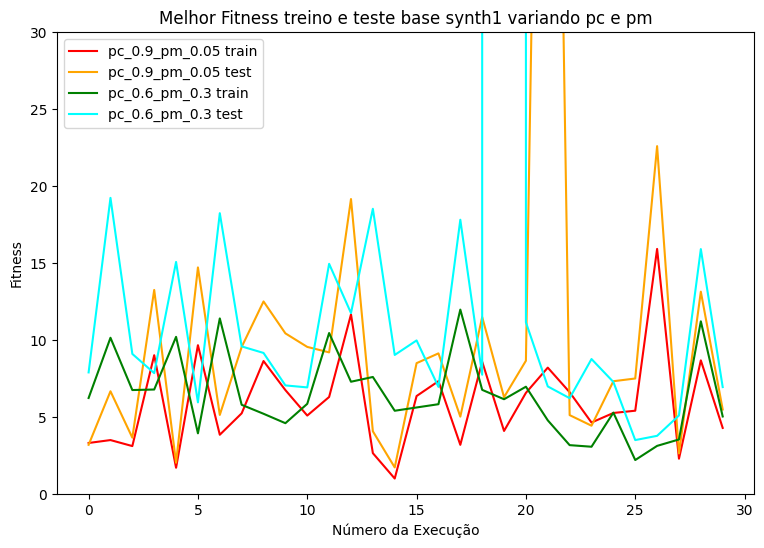

In [29]:
ax = plot_fitness_results(data_per_selection)
ax.set_ylim((0, 30))
plt.show()

In [30]:
def get_trimmed_mean_train_test_fitness(data_dict, trim=0.05)-> dict[str, dict]:
    config_dict_results = dict()
    for config, data in data_dict.items():
        config_dict_results[config] = dict()
        config_dict_results[config]['train'] = scipy.stats.trim_mean(data.train_fit, trim)
        config_dict_results[config]['test'] = scipy.stats.trim_mean(data.test_fit, trim)
    return config_dict_results

In [33]:
mean_fit_results = get_trimmed_mean_train_test_fitness(data_per_selection)
mean_fit_results

{'pc_0.9_pm_0.05': {'train': 5.80026628373831, 'test': 8.600472132319073},
 'pc_0.6_pm_0.3': {'train': 6.3793130931584585, 'test': 10.188978888264149}}

In [34]:
simple_stats_dict = [mean_fit_results[config] for config in mean_fit_results.keys()]
results_df = pd.DataFrame.from_records(simple_stats_dict)
results_df.index = ['pc_0.9_pm_0.05', 'pc_0.6_pm_0.3']

In [35]:
results_df

,train,test
pc_0.9_pm_0.05,5.800266,8.600472
pc_0.6_pm_0.3,6.379313,10.188979


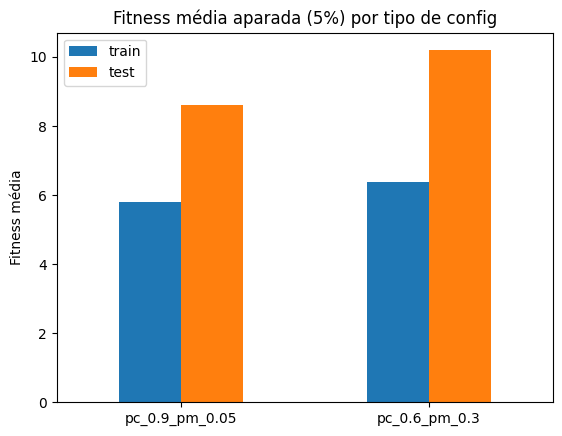

In [41]:
results_df.plot(kind='bar')
plt.title("Fitness média aparada (5%) por tipo de config")
plt.ylabel("Fitness média")
plt.xticks(rotation=0)
plt.show()

A fitness média para a primeira configuração foi levemente melhor do que a segunda.

# 2 - Best fitness ao longo das gerações

In [45]:
def get_500_gen_stats_df_dict_by_run_of_folder(folder):
    files = list(folder.glob("stats*"))
    stats_dict = dict()
    for file in files:
        file_num = str(file).split('_')[-1].split('.')[0]
        stats_dict[int(file_num)] = pd.read_csv(file)
    return stats_dict

In [46]:
results_folders

[PosixPath('../../results/synth1/100pop_500gen'),
 PosixPath('../../results/synth1/100pop_500gen_rol_pc_pm')]

In [47]:
base_pc_pm_config_dfs = get_500_gen_stats_df_dict_by_run_of_folder(results_folders[0])
other_pc_pm_config_dfs = get_500_gen_stats_df_dict_by_run_of_folder(results_folders[1])

In [48]:
def get_line_and_col_of_runs(df_dict, target_line, target_cols:list):
    results_list_of_dicts = list()
    for df_num, df in df_dict.items():
        results_list_of_dicts.append(df.iloc[target_line][target_cols].to_dict())
    
    return pd.DataFrame(results_list_of_dicts)
def get_col_stats_from_dfs_dict(df_dict, target_col):
    records_list = list()
    for gen in range(500):
        curr_values = get_line_and_col_of_runs(df_dict, gen, [target_col]).values.flatten()
        min_value = np.min(curr_values)
        max_value = np.max(curr_values)
        mean_value = np.mean(curr_values)
        new_record = {'min_value':min_value, 'max_value':max_value, 'mean_value':mean_value}
        records_list.append(new_record)

    return pd.DataFrame.from_records(records_list)

In [51]:
best_fit_base_config_df = get_col_stats_from_dfs_dict(base_pc_pm_config_dfs, 'best_fit')
best_fit_other_config_df = get_col_stats_from_dfs_dict(other_pc_pm_config_dfs, 'best_fit')

In [52]:
def plot_fill_between(stats_df, my_axs, label:str):
    x = range(len(stats_df))
    y = stats_df['mean_value']
    y1 = stats_df['min_value']
    y2 = stats_df['max_value']
    my_axs.plot(x, y, '-', label=label)
    my_axs.fill_between(x, y1, y2, alpha=0.2)

Text(0.5, 1.0, 'Melhor fitness média para 30 runs e 100 indivíduos')

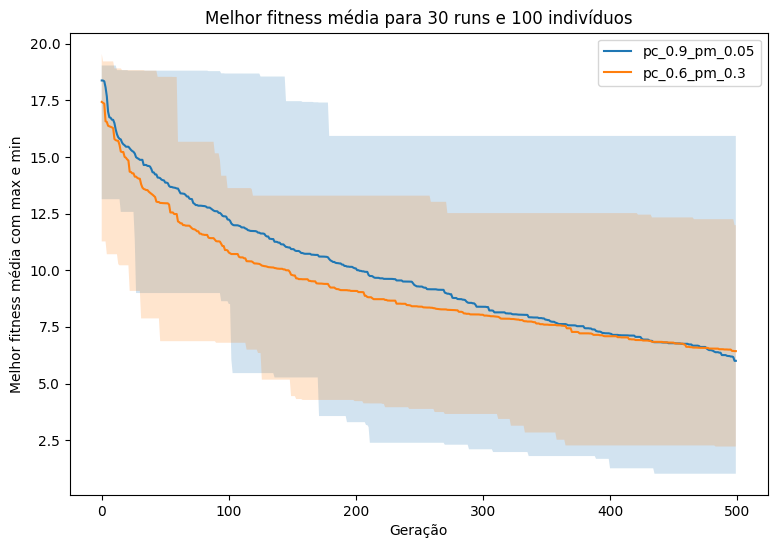

In [53]:
fig, ax = plt.subplots(figsize=(9, 6))
plot_fill_between(best_fit_base_config_df, ax, 'pc_0.9_pm_0.05')
plot_fill_between(best_fit_other_config_df, ax, 'pc_0.6_pm_0.3')

ax.legend()
ax.set_ylabel("Melhor fitness média com max e min")
ax.set_xlabel("Geração")
ax.set_title("Melhor fitness média para 30 runs e 100 indivíduos")

O gráfico mostra que, na média, a nova configuração tem uma força maior para melhorar as soluções. Isso pode indicar que existe um ganho entre aumentar a probabilidade de mutação e diminuir um pouco a de crossover. Entretanto, a medida que as iterações passam, a taxa de melhora vai diminuindo e, já ao redor de 480 iterações, a configuração original possui um indivíduo melhor, em média, do que a configuração nova. 

# 3 - Comparando as melhores execuções par ambas configurações

In [54]:
def get_best_test_line_for_selection(select_type):
    target = f'{select_type}'
    config = data_per_selection[select_type]
    print(f"Melhor linha para seleção {select_type}: ")
    best_run = config[config.test_fit == config.test_fit.min()] 
    print(best_run)
    return best_run

In [56]:
base_best_run_stats = get_best_test_line_for_selection('pc_0.9_pm_0.05')
other_best_run_stats = get_best_test_line_for_selection('pc_0.6_pm_0.3')

Melhor linha para seleção pc_0.9_pm_0.05: 
    train_fit  test_fit  train_time_seconds  random_seed
14   1.018772  1.740526           58.360054          568
Melhor linha para seleção pc_0.6_pm_0.3: 
    train_fit  test_fit  train_time_seconds  random_seed
25   2.220124   3.51596           16.819384          682


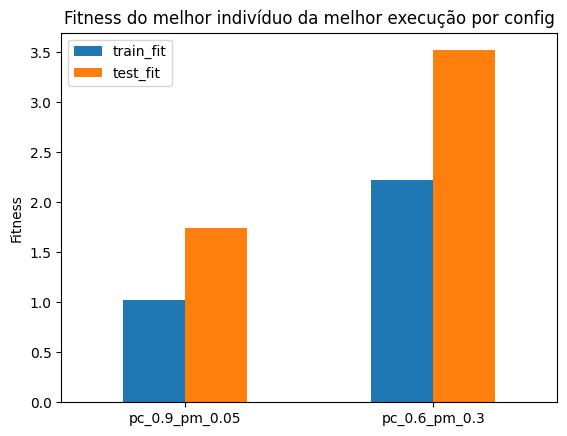

In [59]:
records = [base_best_run_stats[['train_fit','test_fit']].iloc[0].to_dict(),
            other_best_run_stats[['train_fit','test_fit']].iloc[0].to_dict()]
best_run_stats_df = pd.DataFrame.from_records(records)
best_run_stats_df.index = ['pc_0.9_pm_0.05', 'pc_0.6_pm_0.3']
best_run_stats_df.plot(kind='bar')
plt.title("Fitness do melhor indivíduo da melhor execução por config")
plt.ylabel("Fitness")
plt.xticks(rotation=0)
plt.show()

A fitness de teste para o melhor indivíduo usando da configuração base é melhor do que a fitness de treino do melhor indivíduo para a outra configuração.

In [62]:
best_base_run = base_pc_pm_config_dfs[14]
best_other_run = other_pc_pm_config_dfs[25]

In [63]:
def plot_run_fill_between(stats_df, my_axs, label:str):
    x = range(len(stats_df))
    min_y = stats_df['best_fit']
    std_y = stats_df['std_fit']
    mean_y = stats_df['mean_fit']
    my_axs.plot(x, min_y, '-', label=label)
    my_axs.fill_between(x, min_y, mean_y, alpha=0.2)

Text(0.5, 1.0, 'Best Fitness ao longo das gerações para as melhores execuções')

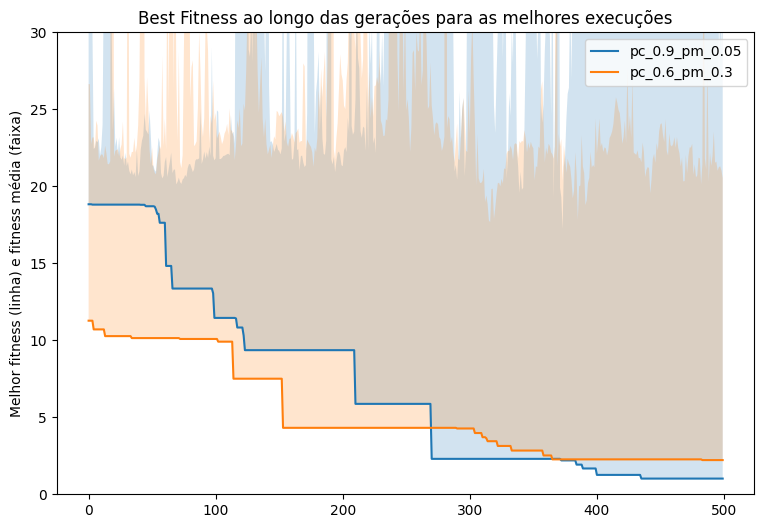

In [66]:
fig, ax = plt.subplots(figsize=(9, 6))
plot_run_fill_between(best_base_run, ax, 'pc_0.9_pm_0.05')
plot_run_fill_between(best_other_run, ax, 'pc_0.6_pm_0.3')

ax.set_ylim((0, 30))
ax.legend()
ax.set_ylabel("Melhor fitness (linha) e fitness média (faixa)")
ax.set_title("Best Fitness ao longo das gerações para as melhores execuções")

O gráfico mostra melhor o movimento em que a nova configuração tem indivíduos melhores nas primeiras gerações mas, já nas últimas gerações, ele produz indivíduos piores do que a configuração base. Dessa forma, vou continuar usando a configuração base.